In [1]:
# import libaries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set Simulation Parameters

Andy Johnson has rented a large industrial hall where he is running a car washing business. His expenses (including rent etc.) are 120 € per day. Currently he employs three (equally efficient and good) workers to whom he (in addition to above expenses) pays an hourly wage of 15 € per person

In [2]:
# set simulation parameters
daily_expenses=120
hour_wage=15

The washing process involves three stages: 1.
- hand washing ($X_1$)
- drying ($X_2$)
- waxing ($X_3$)

Each employee takes care of one stage, and the stages have to be handled in this order for each car, therefore cars may have to wait at each stage if the corresponding worker is busy.

Andy has estimated that the service times (in minutes) for each stage are independent of each other and vary according to normal distribution as follows:
- $X_1∼N(8, 2^2)$
- $X_2∼N(5, 1^2)$
- $X_3∼N(6, 1.5^2)$

The inter-arrival times between cars follow exponential distribution with 6 cars per hour on average. Andy is charging the customers 18 € per car wash.

In [3]:
# set washing time parameters
wash_mu = 8
wash_sigma = 2

# set drying time parameters
dry_mu = 5
dry_sigma = 1

# set waxing time parameters
wax_mu = 6
wax_sigma = 1.5

# set lambda parameter: 6 cars per hour
lam = 6

# set price per customer: 18 euros
price = 18

One working day is assumed to be 8 am-16 pm, i.e. 8 hours. The workers are always paid for 8 hours a day but all customers who start the service before 3:40 pm are served. Any customer waiting in line at 3:40 will get a discount coupon worth 3 €. However, no customers will be accepted to the waiting line after 3:00 pm.

In [4]:
# number of workers, hours per worker, and cost of voucher
workers = 3
daily_hours = 8
voucher_cost = 3

In [5]:
# set time to start: 8:00am
start = np.datetime64('2018-03-20T08:00:00')

# Setup Simulation

In [6]:
# set numpy random state so repeatable results
np.random.seed(42)

In [7]:
# define number of people in day to sample
samples=80

Function for simulating arrival times:

In [8]:
# define a function to simulate the customer arrival times
def arrival_times(lam,samples,start):
    
    # simulate inter-arrival times in seconds (multiply by 3600 and take ceiling)
    inter_arrivals=np.ceil(np.random.exponential(scale=1/lam,size=samples)*3600).astype(int)
    
    # arrival time seconds after start
    arrivals=np.cumsum(inter_arrivals)
    
    # derive arrival time of customer from start time + seconds arrived after start
    arrival_time=np.array([start + int(arrival) for arrival in arrivals])
    
    return arrival_time

Function for simulating service times:

In [9]:
# define a function to simulate the customer service times
def service_times(mu,sigma,samples):
    
    # simulate service times in seconds (multiply *60 and take ceiling)
    X=np.ceil(np.random.normal(mu,sigma,samples)*60).astype(int)
    
    return X    

Function for calculating times that customer is serviced (start/end):

In [10]:
# define a function to calculate the start and end times for each service (wash, dry, wax)
def calculate_times(customer_num,arrival,end_array,service_time):
    
    # set start time to arrival (if staff free) else when the last customer finished
    start = max(arrival,end_array[customer_num-1])
    
    # set end time to start time + service time
    end = start + service_time[customer_num]
    
    return start, end

Function to simulate one day:

In [11]:
# define a function to simulate one dayt at the car wash
def sim_one_day(lam,samples,start,X1_mu,X2_mu,X3_mu,X1_sigma,X2_sigma,X3_sigma,price,
                voucher_cost,workers,daily_hours,hour_wage,daily_expenses):
    
    # simulate arrival times
    arrival_time=arrival_times(lam,samples,start)
    
    # simulate service times
    X1=service_times(X1_mu,X1_sigma,samples)
    X2=service_times(X2_mu,X2_sigma,samples)
    X3=service_times(X3_mu,X3_sigma,samples)
    
    # set start and end times for the first customer
    wash_start = arrival_time[0]
    wash_end = wash_start+X1[0]
    dry_start = wash_end
    dry_end = dry_start + X2[0]
    wax_start = dry_end
    wax_end = wax_start + X3[0]
    
    # initilise empty arrays for storing the start and end times for the customers
    washing_start = np.empty(samples, dtype='datetime64[s]')
    washing_end = np.empty(samples, dtype='datetime64[s]')
    drying_start = np.empty(samples, dtype='datetime64[s]')
    drying_end = np.empty(samples, dtype='datetime64[s]')
    waxing_start = np.empty(samples, dtype='datetime64[s]')
    waxing_end = np.empty(samples, dtype='datetime64[s]')
    
    # set the start times in the arrays for the first customer
    washing_start[0] = wash_start
    washing_end[0] = wash_end
    drying_start[0] = dry_start
    drying_end[0] = dry_end
    waxing_start[0] = wax_start
    waxing_end[0] = wax_end
    
    #### LOOP THROUGH CUSTOMERS AND CALCULATE TIMES
    
    for customer in range(1,samples):
        
        # Set arrival time at car wash
        arrival=arrival_time[customer]
    
        # calculate wash start and end times
        wash_start, wash_end = calculate_times(customer,arrival,end_array=washing_end,service_time=X1)
        washing_start[customer]=wash_start
        washing_end[customer]=wash_end
    
        # Calculate dry start and end times
        dry_start, dry_end = calculate_times(customer,arrival=wash_end,end_array=drying_end,service_time=X2)
        drying_start[customer]=dry_start
        drying_end[customer]=dry_end
    
        # Calculate wax start and end times
        wax_start, wax_end = calculate_times(customer,arrival=dry_end,end_array=waxing_end,service_time=X3)
        waxing_start[customer]=wax_start
        waxing_end[customer]=wax_end

    #### BOOLEANS FOR WHETHER ACCEPTED AND SERVED

    # mask: customers waiting for the wash to start
    waiting_customers = washing_start>arrival_time
    
    # mask: customers arriving before 3
    arrival_before_3 = arrival_time<np.datetime64('2018-03-20T15:00:00')
    
    # mask: customers getting a wash before 3:40
    wash_before_3_40 = washing_start<np.datetime64('2018-03-20T15:40:00')
    
    # customers accepted: i.e. arrival before 3 or arrived between 3:00:3:40 and not waiting
    accepted = (arrival_before_3)|(~arrival_before_3&wash_before_3_40&~waiting_customers)
    
    # customesr served: i.e. accepted + start before 3:40
    served = (accepted&wash_before_3_40)
    
    # customers given voucher for those waiting in line at 3:40: i.e. accepted but not served
    voucher=(accepted==True)&(served==False)
    
    #### CALCULATE METRICS
    
    # calculate profit
    profit = np.sum((served*price)-(voucher*voucher_cost))-(workers*daily_hours*hour_wage)-daily_expenses
    
    # calculate average total waiting time (time not being served at each of the stations)
    wait_time = np.mean((washing_start-arrival_time) + (drying_start-washing_end) 
                        + (waxing_start-drying_end)).astype('timedelta64[m]').astype(int)
    
    # customer served
    customers_served = served.sum()
    
    # vouchers given
    vouchers_given = voucher.sum()
    
    return profit, wait_time, customers_served, vouchers_given  

Function to simulate many days:

In [12]:
def sim_multi(days,lam,samples,start,wash_mu,dry_mu,wax_mu,wash_sigma,dry_sigma,wax_sigma,price,
              voucher_cost,workers,daily_hours,hour_wage,daily_expenses):
    results=np.zeros((days,4))    
    for day in range (0,days):
        results[day,0], results[day,1], results[day,2], results[day,3] = sim_one_day(lam,samples,start,wash_mu,dry_mu,
                                                                                     wax_mu,wash_sigma,dry_sigma,wax_sigma,
                                                                                     price,voucher_cost,workers,daily_hours,
                                                                                     hour_wage,daily_expenses)
    return results

# Simulate and visualise

In [13]:
# Simulate 1000 days
results = sim_multi(1000,lam,samples,start,wash_mu,dry_mu,wax_mu,wash_sigma,dry_sigma,wax_sigma,price,
                    voucher_cost,workers,daily_hours,hour_wage,daily_expenses)

In [14]:
print('Mean profit:',results[:,0].mean())
print('Mean total wait time (mins):',results[:,1].mean())
print('Mean customers served:',results[:,2].mean())
print('Mean vouchers given:',results[:,3].mean())

Mean profit: 289.224
Mean total wait time (mins): 13.847
Mean customers served: 42.763
Mean vouchers given: 0.17


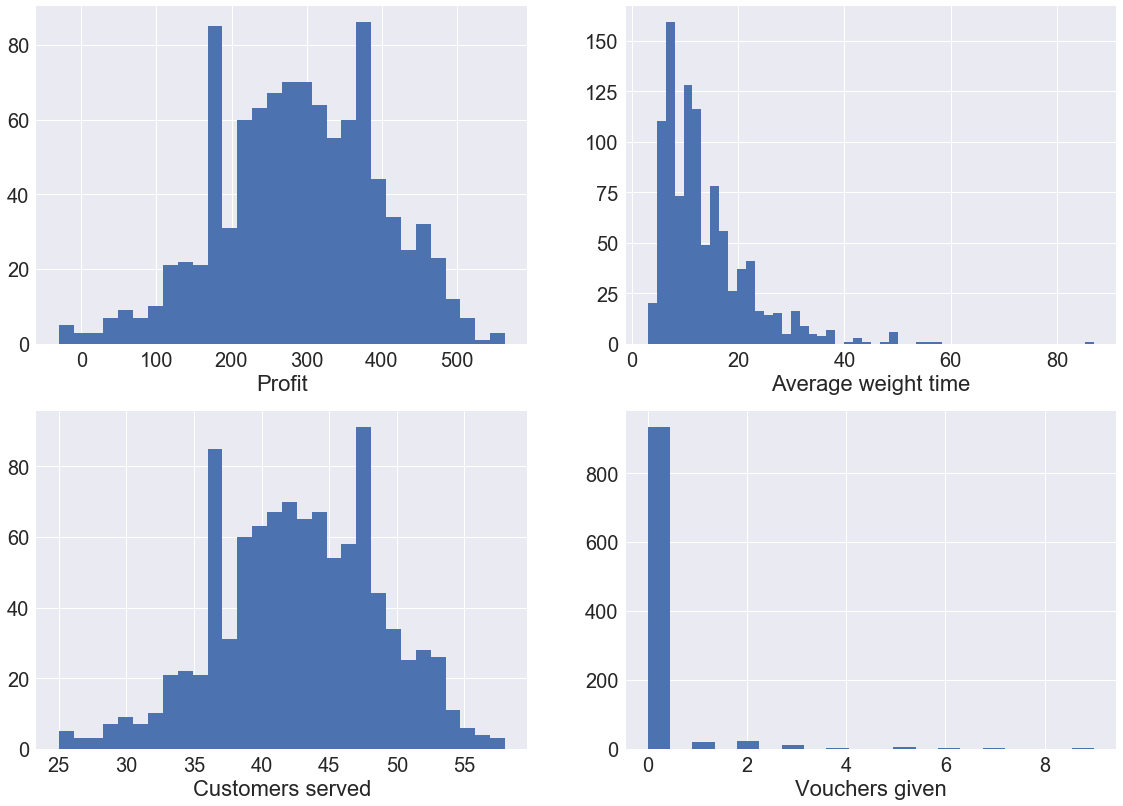

In [15]:
# set font size of charts
sns.set(font_scale=2)

# plot simulated sales
plt.subplot(2,2,1);
plt.hist(results[:,0],bins=30);
plt.xlabel('Profit');

plt.subplot(2,2,2);
plt.hist(results[:,1],bins=50);
plt.xlabel('Average weight time');

plt.subplot(2,2,3);
plt.hist(results[:,2],bins=30);
plt.xlabel('Customers served');

plt.subplot(2,2,4);
plt.hist(results[:,3],bins=20);
plt.xlabel('Vouchers given');

plt.subplots_adjust(left=None, bottom=None, right=2, top=2,wspace=None, hspace=None)
plt.show()